#Training and Validation

## Import library and file

In [41]:
!pip install catboost
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score, roc_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")

# Load feature datasets
X_train_with_outliers = pd.read_csv("X_train_with_outliers.csv")
X_val_with_outliers = pd.read_csv("X_val_with_outliers.csv")
X_test_with_outliers = pd.read_csv("X_test_with_outliers.csv")

X_train_no_outliers = pd.read_csv("X_train_no_outliers.csv")
X_val_no_outliers = pd.read_csv("X_val_no_outliers.csv")
X_test_no_outliers = pd.read_csv("X_test_no_outliers.csv")

# Load target datasets
y_train = pd.read_csv("y_train.csv").values.ravel()  # Flatten to 1D array
y_val = pd.read_csv("y_val.csv").values.ravel()
y_test = pd.read_csv("y_test.csv").values.ravel()

# Load the 10 new patient dataset
heartNewPatients = pd.read_csv('HeartNewPatients.csv')


## Performance comparison of datasets with & without outliers based on 3 models

### Find and apply the best parameters on the 3 models

In [42]:
# Defines a dictionary (check_models) that holds machine learning models
# and their hyperparameter search spaces for tuning later

check_models = {
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
        {
            "classifier__n_estimators": [50, 100, 200],
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__max_depth": [3, 5, 10]
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            "classifier__n_estimators": [50, 100, 200, 300],
            "classifier__max_depth": [5, 10, 20, None],
            "classifier__min_samples_split": [2, 5, 10],
            "classifier__min_samples_leaf": [1, 2, 4],
            "classifier__bootstrap": [True, False]
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=500, random_state=42),
        {
            "classifier__C": [0.01, 0.1, 1, 10],
            "classifier__penalty": ['l1', 'l2'],
            "classifier__solver": ['liblinear', 'saga']
        }
    )
}

In [16]:
# Function to find the best parameter for the 3 algorithms using HalvingRandomSearchCV

def run_halving_search(X, y, dataset_name, models):
    best_estimators = {}

    for model_name, (model, best_params) in models.items():
        print(f"\nRunning HalvingRandomSearchCV for {model_name} on {dataset_name}...")

        # Since the data already scaled in part 1, hence no need to scale the datasets here again
        pipeline = Pipeline([
            ("classifier", model)
        ])

        # Build HalvingRandomSearchCV
        search = HalvingRandomSearchCV(
            estimator=pipeline,
            param_distributions=best_params,
            factor=2,
            resource='n_samples',
            max_resources='auto',
            random_state=42,       # Ensures reproducibility
            verbose=0,             # Ensure clean output
            n_jobs=-1,
            cv=3
        )

        search.fit(X, y)
        print(f"Best parameters for {model_name}: ")
        for param, value in search.best_params_.items():
          print(f"  {param}: {value}")

        # Store best model
        best_estimators[model_name] = search.best_estimator_

    return best_estimators

In [17]:
best_models_with_outliers = run_halving_search(X_train_with_outliers, y_train, "With Outliers", check_models)
best_models_no_outliers = run_halving_search(X_train_no_outliers, y_train, "Without Outliers", check_models)


Running HalvingRandomSearchCV for XGBoost on With Outliers...
Best parameters for XGBoost: 
  classifier__n_estimators: 200
  classifier__max_depth: 10
  classifier__learning_rate: 0.2

Running HalvingRandomSearchCV for RandomForest on With Outliers...
Best parameters for RandomForest: 
  classifier__n_estimators: 300
  classifier__min_samples_split: 2
  classifier__min_samples_leaf: 1
  classifier__max_depth: 20
  classifier__bootstrap: True

Running HalvingRandomSearchCV for LogisticRegression on With Outliers...
Best parameters for LogisticRegression: 
  classifier__solver: saga
  classifier__penalty: l2
  classifier__C: 0.1

Running HalvingRandomSearchCV for XGBoost on Without Outliers...
Best parameters for XGBoost: 
  classifier__n_estimators: 200
  classifier__max_depth: 10
  classifier__learning_rate: 0.2

Running HalvingRandomSearchCV for RandomForest on Without Outliers...
Best parameters for RandomForest: 
  classifier__n_estimators: 300
  classifier__min_samples_split: 2
 

In [18]:
# Defines a dictionary consisting of best parameter combination found for each model (with & without outliers)
models_with_outliers = {
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
        {
            'classifier__n_estimators': 200,
            'classifier__max_depth': 10,
            'classifier__learning_rate': 0.2
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': 300,
            'classifier__min_samples_split': 2,
            'classifier__min_samples_leaf': 1,
            'classifier__max_depth': 20,
            'classifier__bootstrap': True
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=500, random_state=42),
        {
            'classifier__solver': 'saga',
            'classifier__penalty': 'l2',
            'classifier__C': 0.1
        }
    )
}

models_no_outliers = {
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
        {
            'classifier__n_estimators': 200,
            'classifier__max_depth': 10,
            'classifier__learning_rate': 0.2
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': 300,
            'classifier__min_samples_split': 2,
            'classifier__min_samples_leaf': 1,
            'classifier__max_depth': None,
            'classifier__bootstrap': True
        }
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=500, random_state=42),
        {
            'classifier__solver': 'saga',
            'classifier__penalty': 'l2',
            'classifier__C': 0.1
        }
    )
}

###Print out the performance metrics on the 3 models

In [43]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Pred 0', 'Pred 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Function to train model and check the performance and overfitting of train vs val for each model
def train_and_evaluate_model(name, model, best_params, X_train, y_train, X_applied, y_applied, suffix, applied_for):
    print(f"\n========== {name}_{suffix} ==========")

    if name == "VotingClassifier":
        # Model is already trained (Example: VotingClassifier)
        fitted_model = model
    else:
        # Since the data already scaled in part 1, hence no need to scale the datasets here again
        fresh_model = clone(model)  # Clone model to avoid using previous fitted instance
        pipe = Pipeline([('classifier', fresh_model)])
        pipe.set_params(**best_params)
        pipe.fit(X_train, y_train)  # Train with best parameters
        fitted_model = pipe

    if applied_for == "val":
        # Cross-validation on training set
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(fitted_model, X_train, y_train, cv=cv, scoring='roc_auc')
        print(f"\n-- Cross-Validation AUC Scores on Training Data (5-fold) --")
        print(f"Testing Scores: {cv_scores}")
        print(f"Mean AUC: {cv_scores.mean():.4f}, Std Dev: {cv_scores.std():.4f}")

        # Training set evaluation
        y_train_pred = fitted_model.predict(X_train)
        y_train_proba = fitted_model.predict_proba(X_train)[:, 1]  # Probabilities for ROC AUC

        print(f"\n-- {name}_{suffix} on Training Data --")
        print("Classification Report:")
        print(classification_report(y_train, y_train_pred))

        train_roc_auc = roc_auc_score(y_train, y_train_proba)
        print(f"Training ROC AUC Score: {train_roc_auc:.4f}")

    # Validation or testing set evaluation
    y_applied_pred = fitted_model.predict(X_applied)
    y_applied_proba = fitted_model.predict_proba(X_applied)[:, 1]

    print(f"\n-- {name}_{suffix} on {applied_for} Data --")
    print("Classification Report:")
    print(classification_report(y_applied, y_applied_pred))

    applied_roc_auc = roc_auc_score(y_applied, y_applied_proba)
    print(f"{applied_for.capitalize()} ROC AUC Score: {applied_roc_auc:.4f}")

    # For testing dataset, plot confusion matrix
    if applied_for == "test":
        plot_confusion_matrix(y_applied, y_applied_pred, f"{name}_{suffix} - Testing Set Confusion Matrix")

In [20]:
# Train and evaluate the degree of overfitting and performance of models on datasets with outliers
# based on training and validation ROC AUC scores,  cv_mean AUC and classification report
for name, (model, best_params) in models_with_outliers.items():
    train_and_evaluate_model(name, model, best_params,
                             X_train_with_outliers, y_train,
                             X_val_with_outliers, y_val,
                             suffix="with_outliers",
                             applied_for="val")


========== XGBoost_with_outliers ==========

-- Cross-Validation AUC Scores on Training Data (5-fold) --
Testing Scores: [0.99216608 0.97179788 0.99588719 0.97866928 0.99960294]
Mean AUC: 0.9876, Std Dev: 0.0106

-- XGBoost_with_outliers on Training Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       346
         1.0       1.00      1.00      1.00       368

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714

Training ROC AUC Score: 1.0000

-- XGBoost_with_outliers on val Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97        75
         1.0       0.99      0.96      0.97        77

    accuracy                           0.97       152
   macro avg       0.97      0.97      0.97       152
weighted avg       0.97 

In [21]:
# Train and evaluate the degree of overfitting and performance of models on datasets without outliers
# based on training and validation ROC AUC scores,  cv_mean AUC and classification report
for name, (model, best_params) in models_no_outliers.items():
    train_and_evaluate_model(name, model, best_params,
                             X_train_no_outliers, y_train,
                             X_val_no_outliers, y_val,
                             suffix="no_outliers",
                             applied_for="val")


========== XGBoost_no_outliers ==========

-- Cross-Validation AUC Scores on Training Data (5-fold) --
Testing Scores: [0.9902076  0.97179788 0.99490795 0.97964775 1.        ]
Mean AUC: 0.9873, Std Dev: 0.0103

-- XGBoost_no_outliers on Training Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       346
         1.0       1.00      1.00      1.00       368

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714

Training ROC AUC Score: 1.0000

-- XGBoost_no_outliers on val Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        75
         1.0       0.94      0.96      0.95        77

    accuracy                           0.95       152
   macro avg       0.95      0.95      0.95       152
weighted avg       0.95      0

## Apply the datasets with outliers for remaining models

###Find and apply the best parameters on the remaining models

In [22]:
# Since all the 3 models shows that the dataset with outliers perform better
# Use the outliers dataset for remaining models

# Defines a dictionary (remain_models) that holds the other models
# and their hyperparameter search spaces for tuning later

remain_models = {
    "NaiveBayes": (
        GaussianNB(),
        {}  # No hyperparameters to tune
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            "classifier__max_depth": [3, 5, 10, None],
            "classifier__min_samples_split": [2, 5, 10],
            "classifier__min_samples_leaf": [1, 2, 4]
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            "classifier__C": [0.1, 1, 10],
            "classifier__kernel": ["linear", "rbf"],
            "classifier__gamma": ["scale", "auto"]
        }
    ),
    "MLP": (
        MLPClassifier(max_iter=500, random_state=42),
        {
            "classifier__hidden_layer_sizes": [(50,), (100,), (50, 50)],
            "classifier__alpha": [0.0001, 0.001, 0.01],
            "classifier__learning_rate": ['constant', 'adaptive']
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            "classifier__n_neighbors": [3, 5, 7, 9],
            "classifier__weights": ['uniform', 'distance'],
            "classifier__p": [1, 2]
        }
    ),
    "LightGBM": (
        LGBMClassifier(random_state=42, verbose = -1),
        # Hide info/warning, show only errors to ensure clean output
        {
            "classifier__num_leaves": [15, 31, 63],
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__n_estimators": [50, 100, 200],
            "classifier__max_depth": [-1, 10, 20]
        }
    ),
    "CatBoost": (
        CatBoostClassifier(silent=True, random_state=42),
        {
            "classifier__iterations": [100, 200, 300],
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__depth": [3, 6, 10]
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            "classifier__n_estimators": [50, 100, 200],
            "classifier__learning_rate": [0.01, 0.1, 1.0]
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            "classifier__n_estimators": [50, 100, 200],
            "classifier__learning_rate": [0.01, 0.1, 0.2],
            "classifier__max_depth": [3, 5, 10]
        }
    )
}

In [23]:
# Find the best parameters for all the remaining models based on the datasets with outliers
best_remaining_models_with_outliers = run_halving_search(X_train_with_outliers, y_train, "With Outliers", remain_models)


Running HalvingRandomSearchCV for NaiveBayes on With Outliers...
Best parameters for NaiveBayes: 

Running HalvingRandomSearchCV for DecisionTree on With Outliers...
Best parameters for DecisionTree: 
  classifier__min_samples_split: 2
  classifier__min_samples_leaf: 1
  classifier__max_depth: 5

Running HalvingRandomSearchCV for SVM on With Outliers...
Best parameters for SVM: 
  classifier__kernel: linear
  classifier__gamma: auto
  classifier__C: 1

Running HalvingRandomSearchCV for MLP on With Outliers...
Best parameters for MLP: 
  classifier__learning_rate: constant
  classifier__hidden_layer_sizes: (50, 50)
  classifier__alpha: 0.01

Running HalvingRandomSearchCV for KNN on With Outliers...
Best parameters for KNN: 
  classifier__weights: distance
  classifier__p: 2
  classifier__n_neighbors: 3

Running HalvingRandomSearchCV for LightGBM on With Outliers...
Best parameters for LightGBM: 
  classifier__num_leaves: 31
  classifier__n_estimators: 200
  classifier__max_depth: 10
  

In [24]:
# Defines a dictionary consisting of best parameter combination found
# for each remaining model (with outliers)

remain_models = {
      "NaiveBayes": (
        GaussianNB(),
        {}  # No hyperparameters to tune
      ),
     "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            'classifier__min_samples_split': 2,
            'classifier__min_samples_leaf': 1,
            'classifier__max_depth': 5
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            'classifier__kernel': 'linear',
            'classifier__gamma': 'auto',
            'classifier__C': 1
        }
    ),
    "MLP": (
        MLPClassifier(max_iter=500, random_state=42),
        {
            'classifier__learning_rate': 'constant',
            'classifier__hidden_layer_sizes': (50, 50),
            'classifier__alpha': 0.01
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            'classifier__weights': 'distance',
            'classifier__p': 2,
            'classifier__n_neighbors': 3
        }
    ),

    "LightGBM": (
        LGBMClassifier(random_state=42, verbosity=-1),
        # Hide info/warning, show only errors to ensure clean output
        {
            'classifier__num_leaves': 31,
            'classifier__n_estimators': 200,
            'classifier__max_depth': 10,
            'classifier__learning_rate': 0.1
        }
    ),
    "CatBoost": (
        CatBoostClassifier(silent=True, random_state=42),
        {
            'classifier__learning_rate': 0.01,
            'classifier__iterations': 300,
            'classifier__depth': 3
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            'classifier__n_estimators': 100,
            'classifier__learning_rate': 1.0
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'classifier__n_estimators': 50,
            'classifier__max_depth': 5,
            'classifier__learning_rate': 0.2
        }
    )
}


### Print out the performance metrics on the remaining models

In [25]:
# Train and evaluate the degree of overfitting and performance of the remaining models on datasets with outliers
# based on training and validation ROC AUC scores,  cv_mean AUC and classification report
for name, (model, best_params) in remain_models.items():
    train_and_evaluate_model(name, model, best_params,
                             X_train_with_outliers, y_train,
                             X_val_with_outliers, y_val,
                             suffix="with_outliers",
                             applied_for="val")


========== NaiveBayes_with_outliers ==========

-- Cross-Validation AUC Scores on Training Data (5-fold) --
Testing Scores: [0.89717979 0.86799843 0.89424207 0.85675147 0.92416121]
Mean AUC: 0.8881, Std Dev: 0.0237

-- NaiveBayes_with_outliers on Training Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.79      0.82       346
         1.0       0.81      0.89      0.85       368

    accuracy                           0.84       714
   macro avg       0.84      0.84      0.84       714
weighted avg       0.84      0.84      0.84       714

Training ROC AUC Score: 0.8957

-- NaiveBayes_with_outliers on val Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.69      0.76        75
         1.0       0.75      0.88      0.81        77

    accuracy                           0.79       152
   macro avg       0.80      0.79      0.79       152
weighted avg   

##Define a dictionary for all models

In [44]:
# Defines a dictionary consisting of best parameter combination found
# for each model (with outliers) for the convenient of the following codes

all_models = {
    "XGBoost": (
        XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42),
        {
            'classifier__n_estimators': 200,
            'classifier__max_depth': 10,
            'classifier__learning_rate': 0.2
        }
    ),
    "DecisionTree": (
        DecisionTreeClassifier(random_state=42),
        {
            'classifier__min_samples_split': 2,
            'classifier__min_samples_leaf': 1,
            'classifier__max_depth': 5
        }
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {
            'classifier__n_estimators': 300,
            'classifier__min_samples_split': 2,
            'classifier__min_samples_leaf': 1,
            'classifier__max_depth': 20,
            'classifier__bootstrap': True
        }
    ),
    "NaiveBayes": (
        GaussianNB(),
        {}  # No hyperparameters to tune
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=500, random_state=42),
        {
            'classifier__solver': 'saga',
            'classifier__penalty': 'l2',
            'classifier__C': 0.1
        }
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {
            'classifier__kernel': 'linear',
            'classifier__gamma': 'auto',
            'classifier__C': 1
        }
    ),
    "MLP": (
        MLPClassifier(max_iter=500, random_state=42),
        {
            'classifier__learning_rate': 'constant',
            'classifier__hidden_layer_sizes': (50, 50),
            'classifier__alpha': 0.01
        }
    ),
    "KNN": (
        KNeighborsClassifier(),
        {
            'classifier__weights': 'distance',
            'classifier__p': 2,
            'classifier__n_neighbors': 3
        }
    ),
    "LightGBM": (
        LGBMClassifier(random_state=42, verbose = -1),
        {
            'classifier__num_leaves': 31,
            'classifier__n_estimators': 200,
            'classifier__max_depth': 10,
            'classifier__learning_rate': 0.1
        }
    ),
    "CatBoost": (
        CatBoostClassifier(silent=True, random_state=42),
        {
            'classifier__learning_rate': 0.01,
            'classifier__iterations': 300,
            'classifier__depth': 3
        }
    ),
    "AdaBoost": (
        AdaBoostClassifier(random_state=42),
        {
            'classifier__n_estimators': 100,
            'classifier__learning_rate': 1.0
        }
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {
            'classifier__n_estimators': 50,
            'classifier__max_depth': 5,
            'classifier__learning_rate': 0.2
        }
    )
}


## Obtain auc score for validation dataset in ascending order

In [45]:
roc_data = {}

def evaluate_models_roc_auc(models_dict, X_train, y_train, X_applied, y_applied, applied_for):
    """
    Trains and evaluates all models using ROC AUC on the validation set with outliers.
    """
    global roc_data
    roc_auc_results = {}

    for name, (model, best_params) in models_dict.items():
        print(f"\n Evaluating {name} on {applied_for} set...")

        if name == "VotingClassifier":
            # Model is already trained (Example: VotingClassifier)
            fitted_model = model
        else:
            # Clone the model to avoid reusing a fitted instance
            fresh_model = clone(model)

            # Construct pipeline with scaler + classifier
            pipe = Pipeline([
                ("classifier", fresh_model)
            ])

            if best_params:
               # Set best parameters (flatten dict if needed)
               pipe.set_params(**best_params)

            # Train the model
            pipe.fit(X_train, y_train)
            fitted_model = pipe

        # Predict probabilities
        if hasattr(fitted_model, "predict_proba"):
            y_proba = fitted_model.predict_proba(X_applied)[:, 1]
        else:
            y_proba = fitted_model.decision_function(X_applied)

        # Calculate ROC AUC
        auc = roc_auc_score(y_applied, y_proba)
        roc_auc_results[name] = auc
        print(f" {name} ROC AUC on {applied_for}: {auc:.4f}")

        # Store FPR/TPR for plotting later
        fpr, tpr, _ = roc_curve(y_applied, y_proba)
        roc_data[name] = (fpr, tpr, auc)

    return roc_auc_results

In [46]:
def plot_roc_curves(roc_data, title="ROC Curves"):
    """
    Plots ROC curves for all models given a dictionary of FPR, TPR, and AUC values.

    Args:
        roc_data (dict): Dictionary with model names as keys and (fpr, tpr, auc) as values.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 8))

    for name, (fpr, tpr, auc) in roc_data.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [47]:
# Evaluate on validation dataset
roc_auc_scores = evaluate_models_roc_auc(
    models_dict=all_models,
    X_train=X_train_with_outliers,
    y_train=y_train,
    X_applied=X_val_with_outliers,
    y_applied=y_val,
    applied_for="validation"
)

# Display sorted scores
print("\n ROC AUC Scores Sorted (Highest to Lowest):\n")
sorted_auc = sorted(roc_auc_scores.items(), key=lambda x: x[1], reverse=True)
for model_name, auc_score in sorted_auc:
    print(f"{model_name:<25}: {auc_score:.4f}")




 Evaluating XGBoost on validation set...
 XGBoost ROC AUC on validation: 0.9897

 Evaluating DecisionTree on validation set...
 DecisionTree ROC AUC on validation: 0.9439

 Evaluating RandomForest on validation set...
 RandomForest ROC AUC on validation: 0.9900

 Evaluating NaiveBayes on validation set...
 NaiveBayes ROC AUC on validation: 0.8705

 Evaluating LogisticRegression on validation set...
 LogisticRegression ROC AUC on validation: 0.9081

 Evaluating SVM on validation set...
 SVM ROC AUC on validation: 0.9046

 Evaluating MLP on validation set...
 MLP ROC AUC on validation: 0.9875

 Evaluating KNN on validation set...
 KNN ROC AUC on validation: 0.9670

 Evaluating LightGBM on validation set...
 LightGBM ROC AUC on validation: 0.9894

 Evaluating CatBoost on validation set...
 CatBoost ROC AUC on validation: 0.9474

 Evaluating AdaBoost on validation set...
 AdaBoost ROC AUC on validation: 0.9478

 Evaluating GradientBoosting on validation set...
 GradientBoosting ROC AUC on

## Get top 3 models to build voting model

In [48]:
# Extract top 3 models for voting
top_3_models = [name for name, _ in sorted_auc[:3]]

# Utility function to clean 'classifier__' prefix
def clean_params(params_dict):
    return {
        key.split("__")[1]: value
        for key, value in params_dict.items()
        if key.startswith("classifier__")
    }

# Prepare individual classifiers
estimators = []
for name in top_3_models:
    model_cls = all_models[name][0].__class__
    raw_params = all_models[name][1]
    cleaned_params = clean_params(raw_params)

    if name == "XGBoost":
        cleaned_params.update({"use_label_encoder": False, "eval_metric": "logloss"})

    model = model_cls(**cleaned_params)
    model.fit(X_train_with_outliers, y_train)
    estimators.append((name.lower(), model))



In [49]:
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

pipe = Pipeline([
    ("voting_clf", voting_clf)
])

pipe.fit(X_train_with_outliers, y_train)

# Add VotingClassifier into all_models
all_models["VotingClassifier"] = (pipe.named_steps["voting_clf"], {})

In [50]:
name = "VotingClassifier"
model, best_params = all_models[name]

train_and_evaluate_model(
    name, model, best_params,
    X_train_with_outliers, y_train,
    X_test_with_outliers, y_test,
    suffix="with_outliers",
    applied_for="val"
)


========== VotingClassifier_with_outliers ==========

-- Cross-Validation AUC Scores on Training Data (5-fold) --
Testing Scores: [0.99764982 0.97708578 0.99745398 0.99569472 0.99960294]
Mean AUC: 0.9935, Std Dev: 0.0083

-- VotingClassifier_with_outliers on Training Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       346
         1.0       1.00      1.00      1.00       368

    accuracy                           1.00       714
   macro avg       1.00      1.00      1.00       714
weighted avg       1.00      1.00      1.00       714

Training ROC AUC Score: 1.0000

-- VotingClassifier_with_outliers on val Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        75
         1.0       1.00      0.97      0.99        80

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       1

In [51]:
# Predict probabilities and evaluate AUC
y_proba = pipe.predict_proba(X_val_with_outliers)[:, 1]
auc = roc_auc_score(y_val, y_proba)

print(f" VotingClassifier ROC AUC: {auc:.4f}")

# Save for plotting
fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_data["VotingClassifier"] = (fpr, tpr, auc)

 VotingClassifier ROC AUC: 0.9894


## Print ROC curves for validation dataset

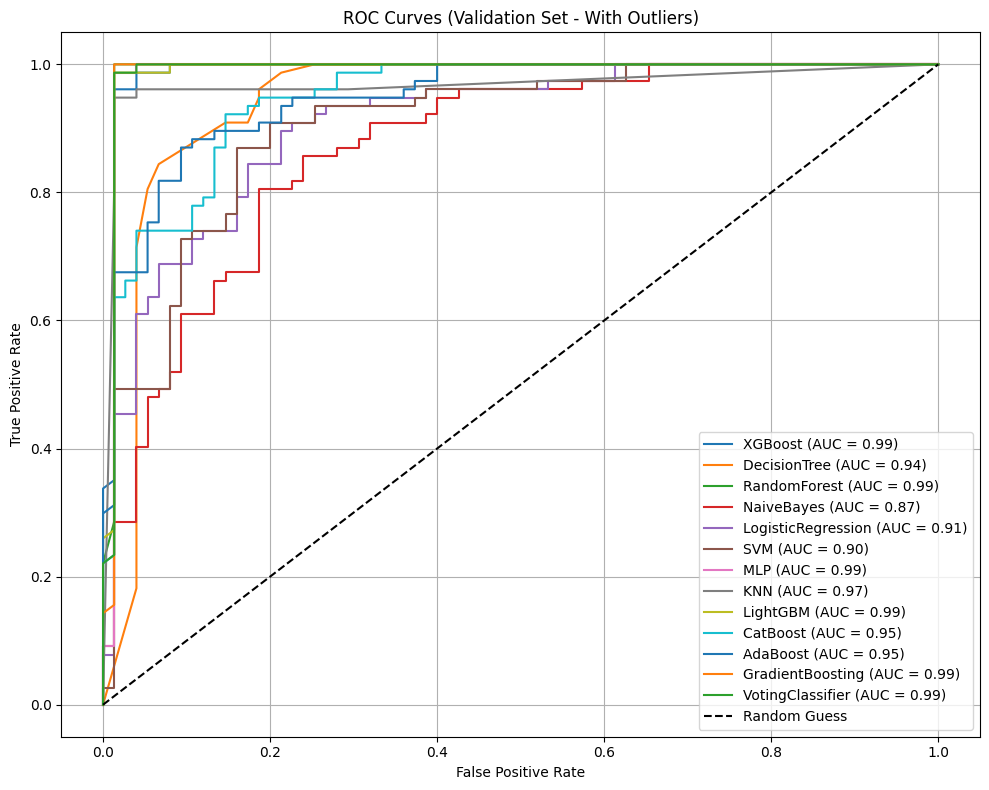

In [52]:
# Plot ROC curves for validation set
plot_roc_curves(roc_data, title="ROC Curves (Validation Set - With Outliers)")

#Testing

###Print out the performance metrics and confusion matrix for all models


========== XGBoost_with_outliers ==========

-- XGBoost_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        75
         1.0       1.00      0.96      0.98        80

    accuracy                           0.98       155
   macro avg       0.98      0.98      0.98       155
weighted avg       0.98      0.98      0.98       155

Test ROC AUC Score: 0.9983


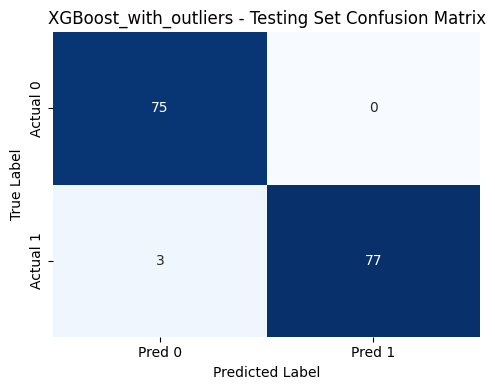


========== DecisionTree_with_outliers ==========

-- DecisionTree_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.84      0.89        75
         1.0       0.87      0.96      0.91        80

    accuracy                           0.90       155
   macro avg       0.91      0.90      0.90       155
weighted avg       0.91      0.90      0.90       155

Test ROC AUC Score: 0.9658


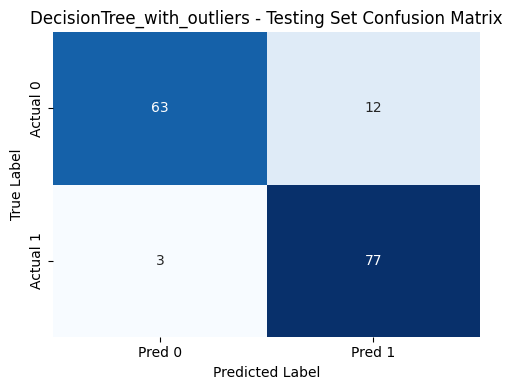


========== RandomForest_with_outliers ==========

-- RandomForest_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        75
         1.0       1.00      0.97      0.99        80

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155

Test ROC AUC Score: 1.0000


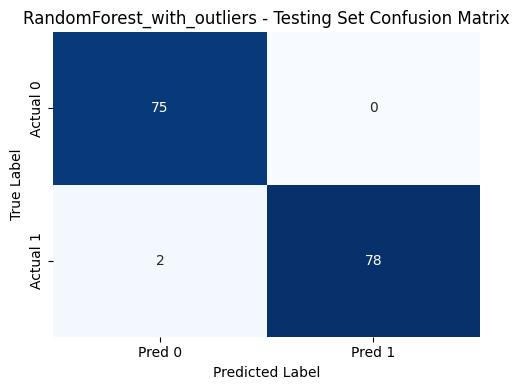


========== NaiveBayes_with_outliers ==========

-- NaiveBayes_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.75      0.79        75
         1.0       0.79      0.88      0.83        80

    accuracy                           0.81       155
   macro avg       0.82      0.81      0.81       155
weighted avg       0.82      0.81      0.81       155

Test ROC AUC Score: 0.8565


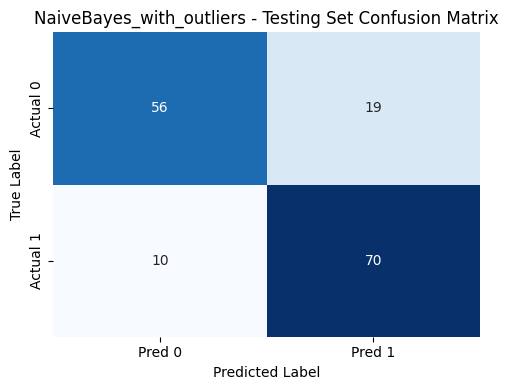


========== LogisticRegression_with_outliers ==========

-- LogisticRegression_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83        75
         1.0       0.80      0.95      0.87        80

    accuracy                           0.85       155
   macro avg       0.87      0.85      0.85       155
weighted avg       0.86      0.85      0.85       155

Test ROC AUC Score: 0.9210


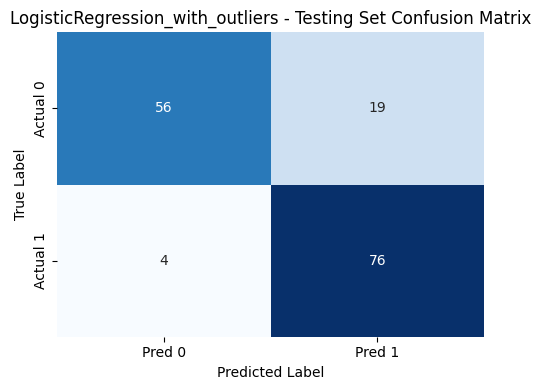


========== SVM_with_outliers ==========

-- SVM_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83        75
         1.0       0.80      0.95      0.87        80

    accuracy                           0.85       155
   macro avg       0.87      0.85      0.85       155
weighted avg       0.86      0.85      0.85       155

Test ROC AUC Score: 0.9182


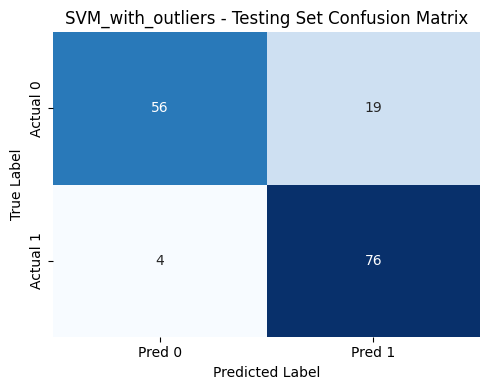


========== MLP_with_outliers ==========

-- MLP_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        75
         1.0       1.00      0.97      0.99        80

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155

Test ROC AUC Score: 0.9997


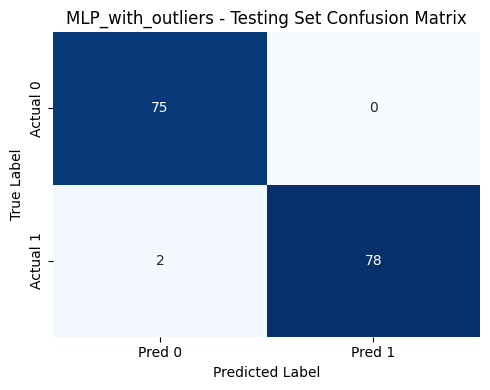


========== KNN_with_outliers ==========

-- KNN_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96        75
         1.0       1.00      0.93      0.96        80

    accuracy                           0.96       155
   macro avg       0.96      0.96      0.96       155
weighted avg       0.96      0.96      0.96       155

Test ROC AUC Score: 0.9752


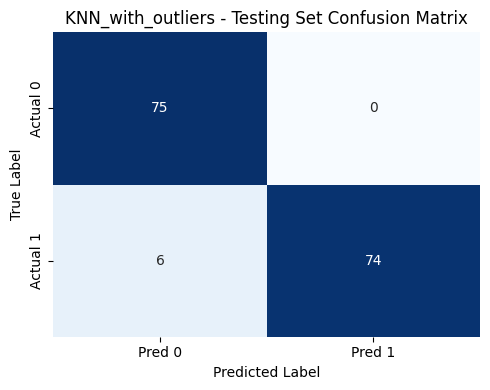


========== LightGBM_with_outliers ==========

-- LightGBM_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        75
         1.0       1.00      0.97      0.99        80

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155

Test ROC AUC Score: 0.9987


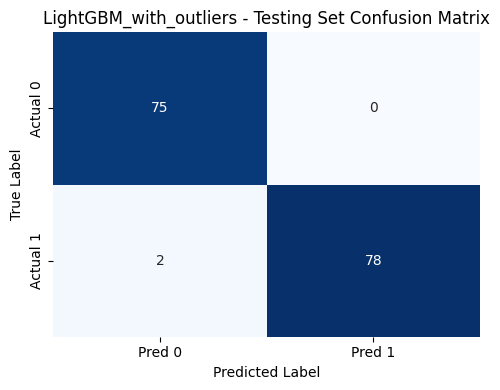


========== CatBoost_with_outliers ==========

-- CatBoost_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.81      0.88        75
         1.0       0.85      0.96      0.90        80

    accuracy                           0.89       155
   macro avg       0.90      0.89      0.89       155
weighted avg       0.90      0.89      0.89       155

Test ROC AUC Score: 0.9477


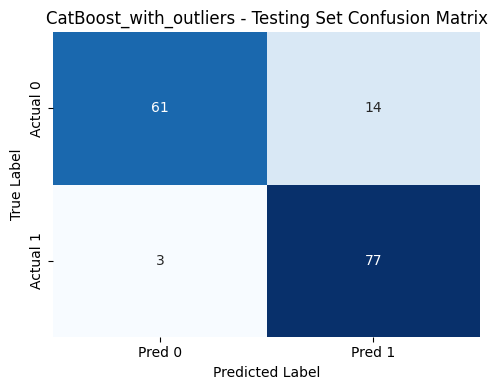


========== AdaBoost_with_outliers ==========

-- AdaBoost_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86        75
         1.0       0.85      0.90      0.87        80

    accuracy                           0.86       155
   macro avg       0.87      0.86      0.86       155
weighted avg       0.87      0.86      0.86       155

Test ROC AUC Score: 0.9458


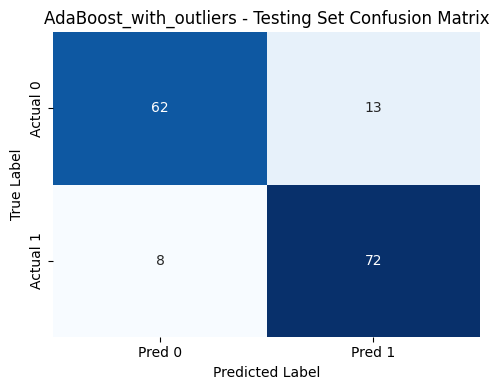


========== GradientBoosting_with_outliers ==========

-- GradientBoosting_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        75
         1.0       1.00      0.96      0.98        80

    accuracy                           0.98       155
   macro avg       0.98      0.98      0.98       155
weighted avg       0.98      0.98      0.98       155

Test ROC AUC Score: 0.9990


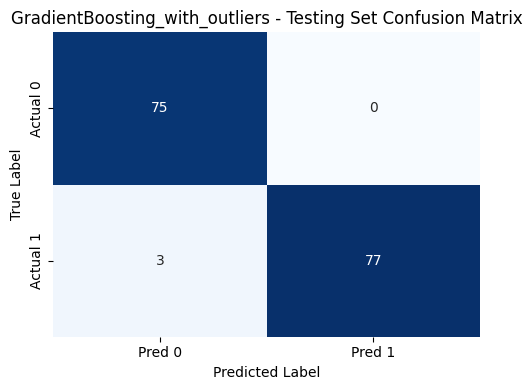


========== VotingClassifier_with_outliers ==========

-- VotingClassifier_with_outliers on test Data --
Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99        75
         1.0       1.00      0.97      0.99        80

    accuracy                           0.99       155
   macro avg       0.99      0.99      0.99       155
weighted avg       0.99      0.99      0.99       155

Test ROC AUC Score: 1.0000


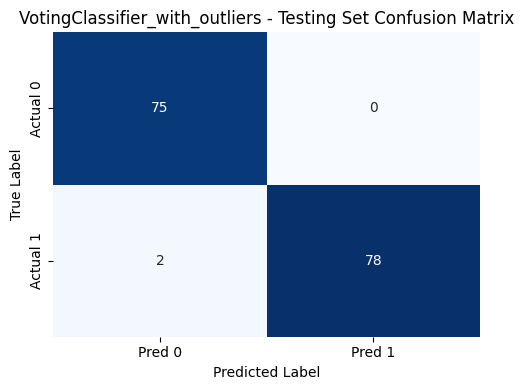

In [53]:
for name, (model, best_params) in all_models.items():
  train_and_evaluate_model(name, model, best_params,
                           X_train_with_outliers, y_train,
                           X_test_with_outliers, y_test,
                           suffix="with_outliers",
                           applied_for="test")

## Obtain auc score for testing dataset in ascending order

In [54]:
roc_data_testing = {}

# Evaluate on testing dataset
roc_auc_scores = evaluate_models_roc_auc(
    models_dict=all_models,
    X_train=X_train_with_outliers,
    y_train=y_train,
    X_applied=X_test_with_outliers,
    y_applied=y_test,
    applied_for="testing"
)

# Display sorted scores
print("\n ROC AUC Scores Sorted (Highest to Lowest):\n")
sorted_auc = sorted(roc_auc_scores.items(), key=lambda x: x[1], reverse=True)
for model_name, auc_score in sorted_auc:
    print(f"{model_name:<25}: {auc_score:.4f}")


 Evaluating XGBoost on testing set...
 XGBoost ROC AUC on testing: 0.9983

 Evaluating DecisionTree on testing set...
 DecisionTree ROC AUC on testing: 0.9658

 Evaluating RandomForest on testing set...
 RandomForest ROC AUC on testing: 1.0000

 Evaluating NaiveBayes on testing set...
 NaiveBayes ROC AUC on testing: 0.8565

 Evaluating LogisticRegression on testing set...
 LogisticRegression ROC AUC on testing: 0.9210

 Evaluating SVM on testing set...
 SVM ROC AUC on testing: 0.9182

 Evaluating MLP on testing set...
 MLP ROC AUC on testing: 0.9997

 Evaluating KNN on testing set...
 KNN ROC AUC on testing: 0.9752

 Evaluating LightGBM on testing set...
 LightGBM ROC AUC on testing: 0.9987

 Evaluating CatBoost on testing set...
 CatBoost ROC AUC on testing: 0.9477

 Evaluating AdaBoost on testing set...
 AdaBoost ROC AUC on testing: 0.9458

 Evaluating GradientBoosting on testing set...
 GradientBoosting ROC AUC on testing: 0.9990

 Evaluating VotingClassifier on testing set...
 Vot

## Print ROC curves for testing dataset

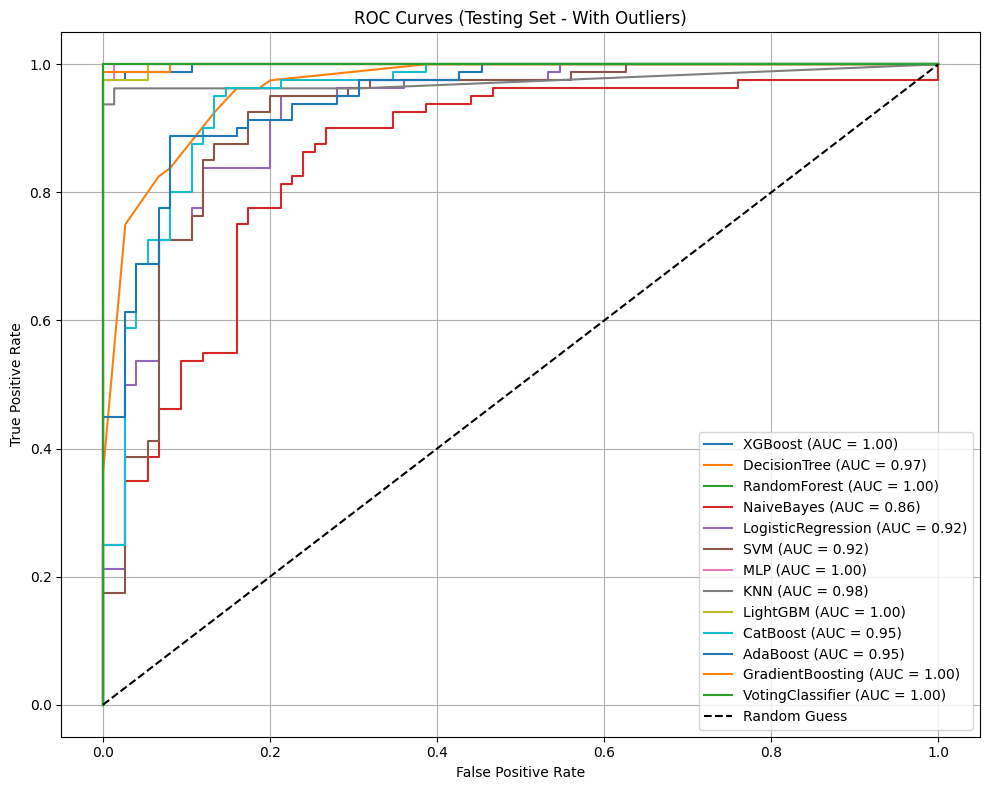

In [37]:
# Plot ROC curves on testing dataset
plot_roc_curves(roc_data, title="ROC Curves (Testing Set - With Outliers)")

#Storing Final Model

In [38]:
model_name = "RandomForest"
model_cls, best_params = all_models[model_name]

# Train the model with the best parameters
model = model_cls
model.fit(X_train_with_outliers, y_train)

# Save the model
joblib.dump(model, 'random_forest_model_with_outliers.pkl')

['random_forest_model_with_outliers.pkl']

# Prediction

In [39]:
def predict_user_data(user_df, scaler_path='scaler.pkl',
                      one_hot_encoder_path='onehot_encoder_with_outliers.pkl',
                      ordinal_encoder_path='ordinal_encoder_with_outliers.pkl'):
    """
    Load the trained model and preprocess the user data, then make predictions.

    Parameters:
        user_df (pd.DataFrame): DataFrame with user input for prediction.
        scaler_path (str): Path to the saved scaler model.
        one_hot_encoder_path (str): Path to the saved OneHotEncoder model.
        ordinal_encoder_path (str): Path to the saved OrdinalEncoder model.

    Returns:
        np.ndarray: Predictions from the model.
    """
    # Load the model
    model = joblib.load('random_forest_model_with_outliers.pkl')

    # Load the pre-trained preprocessing objects
    scaler = joblib.load(scaler_path)
    one_hot_encoder = joblib.load(one_hot_encoder_path)
    ordinal_encoder = joblib.load(ordinal_encoder_path)

    # Specify the columns for preprocessing
    numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    ordinal_cols = ['ca', 'slope']
    one_hot_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'thal']

    # Drop the target column if exists
    if 'target' in user_df.columns:
        user_df = user_df.drop(columns='target')

    # Standardize numerical features
    user_df[numerical_cols] = scaler.transform(user_df[numerical_cols])

    # One-hot encoding
    one_hot_encoded = one_hot_encoder.transform(user_df[one_hot_cols])
    one_hot_col_names = one_hot_encoder.get_feature_names_out(one_hot_cols)
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=one_hot_col_names, index=user_df.index)

    # Ordinal encoding
    ordinal_encoded = ordinal_encoder.transform(user_df[ordinal_cols])
    ordinal_col_names = [f"{col}_encoded" for col in ordinal_cols]
    ordinal_df = pd.DataFrame(ordinal_encoded, columns=ordinal_col_names, index=user_df.index)

    # Drop original categorical columns
    user_df = user_df.drop(columns=one_hot_cols + ordinal_cols)

    # Combine all features
    final_input = pd.concat([user_df, one_hot_df, ordinal_df], axis=1)

    # Make prediction using the model
    predictions = model.predict(final_input)

    return predictions

In [40]:
# Predict using the function
preds = predict_user_data(heartNewPatients)

print(preds)

[0. 1. 0. 0. 1. 0. 1. 1. 1. 1.]
